# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


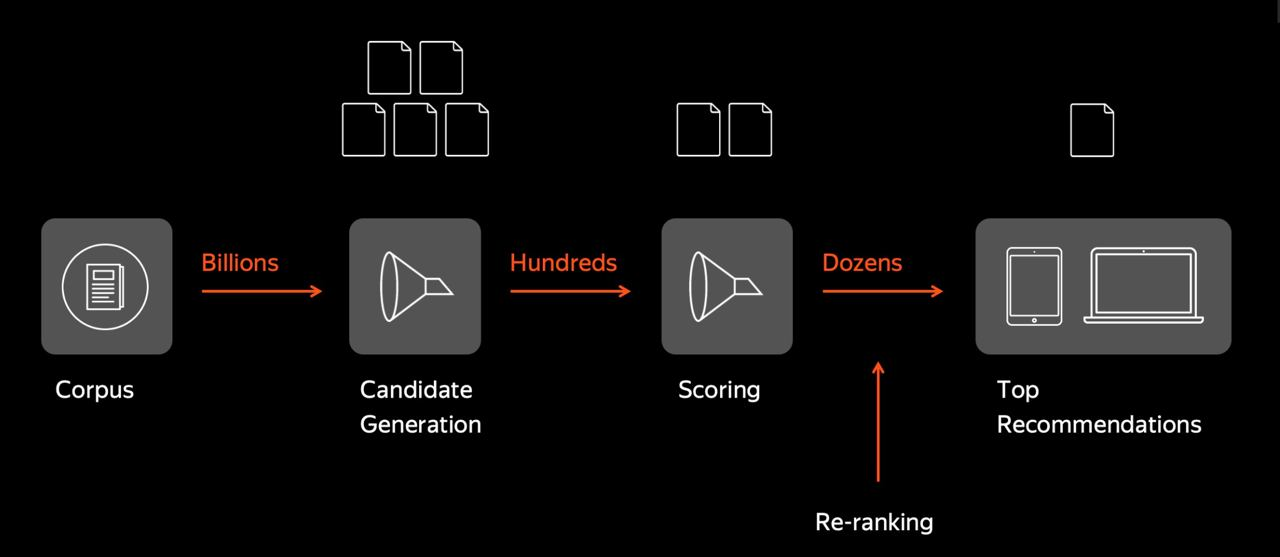

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def pk(relevant: List[int], predicted: List[int], k: int):
    return np.cumsum(np.isin(predicted[:k], relevant)) / np.arange(1, k + 1)

def apk(relevant: List[int], predicted: List[int], k: int):
    p_k = pk(relevant, predicted, k)
    return np.sum(np.isin(predicted[:k], relevant) * p_k) / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    apks = []
    for i in range(len(relevant)):
        apks.append(apk(relevant[i], predicted[i], k))
    return np.mean(apks)


In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        for user_id in range(self.n_users):
            test_preds += [self.recommend(user_id)]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def row_jaccard(a, user_vector):
    return len(np.where((a > 0) & (user_vector > 0))[0]) / len(np.where((a > 0) | (user_vector > 0))[0])

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.apply_along_axis(row_jaccard, 1, ratings, user_vector).ravel()

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [17]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        simil = self.similarity(self.R[uid])
        users = np.where(simil > self.alpha)[0]
        users = users[users != uid]
        scores = simil[users] @ self.R[users]
        return (scores).argsort()[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [18]:
cnt = 50

model = User2User(train_ratings)
recomend_u2u = model.get_test_recommendations(cnt)

random_tracks = np.random.choice(ratings['trackId'].unique(), cnt)

recomend_random = np.array(list(random_tracks for _ in test_users))

popular_tracks = np.argsort(-np.sum(model.R, axis=0))[:cnt]

recomend_popular = np.array(list(popular_tracks for _ in test_users))


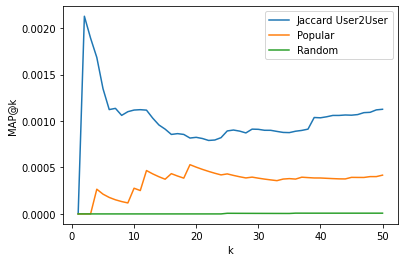

In [19]:
default_range = range(1, cnt + 1)
plt.plot(default_range, list(mapk(test_relevant, recomend_u2u, k) for k in default_range), label='Jaccard User2User')
plt.plot(default_range, list(mapk(test_relevant, recomend_popular, k) for k in default_range), label='Popular')
plt.plot(default_range, list(mapk(test_relevant, recomend_random, k) for k in default_range), label='Random')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [21]:
user_id = np.random.randint(0, model.n_users)

In [22]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


<ipython-input-22-b8c41e21a5ba>:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]


,name,artists
886,In The Army Now,['Status Quo']
927,Set The World On Fire,['E-Type']
1019,It's My Life,['Bon Jovi']
1407,Angels (Love Is The Answer),['Morandi']
1448,Here I Go Again,['E-Type']
1468,Russian Lullaby,['E-Type']
1740,Roses Are Red,['Aqua']
2038,Невеста,"[""Глюк'oZa""]"
2211,Икона,['Бутырка']
2233,Девчонка с центра,['Бутырка']


In [23]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
12262,Demons,['Imagine Dragons']
59463,GOOBA,['6ix9ine']
49577,Кукла колдуна,['Король и Шут']
6773,Back in Black,['AC/DC']
48230,Цепи,"['Скриптонит', '104']"
59229,Мальчик на девятке,['DEAD BLONDE']
6745,Chop Suey!,['System of A Down']
48282,Мультибрендовый,"['Скриптонит', '104', 'T-Fest', 'Niman']"
10641,Тополиный пух,['Иванушки International']
35064,Thunder,['Imagine Dragons']


In [24]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


<ipython-input-24-dc60047a9784>:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]


,name,artists
57703,Ты моё,"['StaFFорд63', 'Яна Вайновская']"
58007,Kings & Queens,['Ava Max']
58250,Наливай винишко,['ARi Sam Vii']
59557,Протест,['Патология']
60761,Gin Tonic (Think About the Way),"['Dino Brown', 'Paky Francavilla', 'Ice MC', '..."
60917,По ресторанам,"['Руслан Набиев', 'DJ Fat Maxx']"
61292,Ты обнимаешь меня,['Светлана Снаткина']
61515,Звезда разлуки,['Русский Размер']
61516,Лети,['Русский Размер']
61759,Весна,['Русский Размер']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$\nabla_{p_u} L = 2\sum_{i} (p_u^Tq_i^2 - r_{ui}q_i) + 2\lambda p_u$ 

$\nabla_{q_u} L = 2\sum_{i} (q_i^Tp_u^2 - r_{ui}p_u) + 2\lambda q_i$ 

Шаг в SGD берется для одного элемента из выборки $r_{ui}$:

$p_u = p_u - lr ((p_u^Tq_i^2 - r_{ui}q_i) + \lambda p_u) $ 

$q_i = q_i - lr ((q_i^Tp_u^2 - r_{ui}p_u) + \lambda q_i) $ 

**ALS:**

$L = ||(R - P^TQ)||_F^2 + \lambda(||P||_F^2 + ||Q||_F^2)$

Вычислим для $P$:

$d_PL = d(tr((R - P^TQ)^T(R - P^TQ))) + d\lambda tr(P^TP) = \\ 2tr((R - P^TQ)^T(-dP^TQ)) + 2tr(\lambda P^TdP) = tr(2((P^TQ - R)Q^T + \lambda P^T)dP)$

$\nabla_{P} L = 2(Q(P^TQ - R)^T + \lambda P)$ 

$2(Q(P^TQ - R)^T + \lambda P) = 0$ 

$P = (QQ^T + \lambda)^{-1}QR^T$ 

Аналогично для $Q$:

$Q = (PP^T + \lambda)^{-1}PR$ 




**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [25]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.1

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                u = np.random.randint(0, self.n_users)
                i = np.random.randint(0, self.n_items)
                p = self.P[u, :]
                q = self.Q[i, :]
                pq = self.P[u, :] @ self.Q[i, :]
                self.P[u, :] = p - self.lr * (pq * q - self.R[u][i] * q + self.lamb * p)
                self.Q[i, :] = q - self.lr * (pq * p - self.R[u][i] * p + self.lamb * q)

            elif self.mode == 'als':
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.identity(self.dim)) @ self.Q.T @ self.R.T).T
                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.identity(self.dim)) @ self.P.T @ self.R).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [26]:

params_sgd = {"dim" : None, "k" : None, "mapk" : 0}

for dim in tqdm(range(30, 250, 10)):
    model_it =  LatentFactorModel(train_ratings, dim = dim, mode = "sgd")
    model_it.fit(500000)
    result = model_it.get_test_recommendations(50)
    for k in range(1, 51):
        cur_mapk = mapk(test_relevant, result, k)
        if cur_mapk > params_sgd["mapk"]:
            params_sgd["dim"] = dim
            params_sgd["k"] = k
            params_sgd["mapk"] = cur_mapk

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

In [27]:
params_sgd

{'dim': 130, 'k': 1, 'mapk': 0.00425531914893617}

In [28]:
mapks_sgd = []
model_it =  LatentFactorModel(train_ratings, dim = params_sgd["dim"], mode = "sgd")
cur = 0
for iter in [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 750000, 1000000]:
    model_it.fit(iter - cur)
    cur = iter
    result = model_it.get_test_recommendations(50)
    mapks_sgd.append(mapk(test_relevant, result, 2))
    print(mapks_sgd[-1])


  0%|          | 0/100 [00:00<?, ?it/s]

0.0


  0%|          | 0/400 [00:00<?, ?it/s]

0.0


  0%|          | 0/500 [00:00<?, ?it/s]

0.0


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0


  0%|          | 0/40000 [00:00<?, ?it/s]

0.0


  0%|          | 0/50000 [00:00<?, ?it/s]

0.0


  0%|          | 0/400000 [00:00<?, ?it/s]

0.0


  0%|          | 0/250000 [00:00<?, ?it/s]

0.0


  0%|          | 0/250000 [00:00<?, ?it/s]

0.0


(0.0001, 0.01)

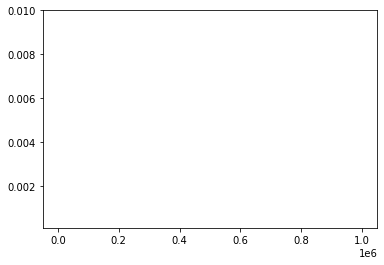

In [29]:
plt.plot([100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 750000, 1000000], mapks_sgd)
plt.ylim([0.0001, 0.01])

In [30]:
model_sgd =  LatentFactorModel(train_ratings, dim = params_sgd["dim"], mode = "sgd")
model_sgd.fit(500000)
result_sgd = model_it.get_test_recommendations(50)
print(mapk(test_relevant, result, params_sgd["k"]))

  0%|          | 0/500000 [00:00<?, ?it/s]

0.0


In [31]:

params_als = {"dim" : None, "k" : None, "mapk" : 0}

for dim in tqdm(range(10, 250, 10)):
    model_it =  LatentFactorModel(train_ratings, dim = dim, mode = "als")
    model_it.fit(50)
    result = model_it.get_test_recommendations(50)
    for k in range(1, 51):
        cur_mapk = mapk(test_relevant, result, k)
        if cur_mapk > params_als["mapk"]:
            params_als["dim"] = dim
            params_als["k"] = k
            params_als["mapk"] = cur_mapk

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
params_als

{'dim': 90, 'k': 1, 'mapk': 0.00851063829787234}

In [88]:
mapks_als = []
iters = list(range(10, 101, 10))
model_als =  LatentFactorModel(train_ratings, dim = params_als["dim"], mode = "als")
cur = 0
for iter in range(10, 101, 10):
    model_als.fit(iter - cur)
    cur = iter
    result = model_als.get_test_recommendations(50)
    mapks_als.append(mapk(test_relevant, result, 1))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(0.0001, 0.02)

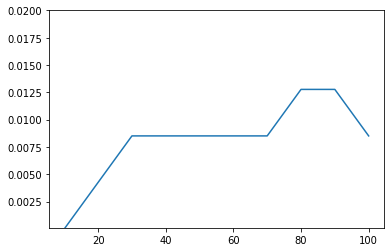

In [89]:
plt.plot(iters, mapks_als)
plt.ylim([0.0001, 0.02])

In [35]:
model_als =  LatentFactorModel(train_ratings, dim = params_als["dim"], mode = "als")
model_als.fit(90)
result_als = model_als.get_test_recommendations(50)
print(mapk(test_relevant, result, params_als["k"]))

  0%|          | 0/90 [00:00<?, ?it/s]

0.01276595744680851


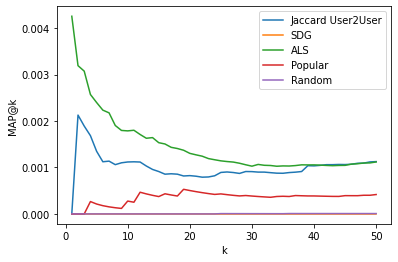

In [36]:
default_range = range(1, cnt + 1)
plt.plot(default_range, list(mapk(test_relevant, recomend_u2u, k) for k in default_range), label='Jaccard User2User')
plt.plot(default_range, list(mapk(test_relevant, result_sgd, k) for k in default_range), label='SDG')
plt.plot(default_range, list(mapk(test_relevant, result_als, k) for k in default_range), label='ALS')
plt.plot(default_range, list(mapk(test_relevant, recomend_popular, k) for k in default_range), label='Popular')
plt.plot(default_range, list(mapk(test_relevant, recomend_random, k) for k in default_range), label='Random')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

Как видите количество итераций влияет в ALS, SGD вообще так себе подход так как в огромной матрице случайным образом берется элемент и попасть в ненулевой вероятность не то что бы высокая. В целом ALS более честный подход, так как учитываются на каждой итерации все элементы, да и результаты явно лучше, так что стоит использовать его.

In [37]:
model = model_als

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [38]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [39]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.657006
2179,Восьмиклассница,['КИНО'],0.610596
5513,Орбит без сахара,['Сплин'],0.548232
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.542796
26075,Лошадка,['Найк Борзов'],0.516672
1039,Get Up I Feel Like Being A Sex Machine,['James Brown'],0.510569
17730,The Mercy Seat,['Nick Cave & The Bad Seeds'],0.510569
17794,Несуразная,['АлоэВера'],0.510569
16786,Previous Crimes,['Devastations'],0.510569


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [40]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [41]:
als_100 = model_als.get_test_recommendations(100)
model_u2u = User2User(train_ratings)
u2u_100 = model_u2u.get_test_recommendations(100)



In [81]:
recomends = np.concatenate((als_100, u2u_100), axis=1)


**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [66]:
item_mean_count = {}
for i in range(model_als.R.shape[1]):
    item_mean_count[i] = model_als.R[:, i].mean()

user_total_count = {}
for i in range(model_als.R.shape[0]):
    user_total_count[i] = model_als.R[i].sum()

In [68]:
user_jaccard_dist = {}
for i in range(model_als.R.shape[0]):
    user_jaccard_dist[i] = np.mean(model_u2u.similarity(model_u2u.R[i]))

In [71]:
listened = np.where(model_als.R == 1)

In [72]:
data = np.concatenate(([listened[0]], [listened[1]]), axis=0).T

In [73]:
user_is_last_50 = {}
for i in range(model_als.R.shape[0]):
    user_is_last_50[i] = set(train_ratings[train_ratings.userId == i]["trackId"][-50:])

<ipython-input-73-10f882b53349>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  user_is_last_50[i] = set(train_ratings[train_ratings.userId == i]["trackId"][-50:])


In [74]:
features = []
for i in range(data.shape[0]):
    row = []
    row.append(model_als.P[data[i][0]] @ model_als.Q[data[i][1]])
    row.append(user_jaccard_dist[data[i][0]])
    row.append(item_mean_count[data[i][1]])
    row.append(user_total_count[data[i][0]])
    row.append(data[i][1] in user_is_last_50[data[i][0]])
    features.append(row)

features = np.array(features)

In [75]:
from sklearn.model_selection import train_test_split
dataset = np.concatenate((data, features), axis=1)
X = dataset[:, :-1]
y = dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [76]:
train_ind = X_train[:, 0].argsort()
X_train = X_train[train_ind]
y_train = y_train[train_ind]

test_ind = X_test[:, 0].argsort()
X_test = X_test[test_ind]
y_test = y_test[test_ind]

In [77]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train[:, 0].astype(int))
test_pool = catboost.Pool(X_test, y_test, group_id=X_test[:, 0].astype(int))

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [78]:
model = catboost.CatBoostClassifier(
    iterations=5000,
    random_seed=42,
)

model.fit(train_pool)

Learning rate set to 0.013685
0:	learn: 0.6687458	total: 62.2ms	remaining: 5m 10s
1:	learn: 0.6443531	total: 102ms	remaining: 4m 13s
2:	learn: 0.6205543	total: 138ms	remaining: 3m 50s
3:	learn: 0.5972575	total: 177ms	remaining: 3m 40s
4:	learn: 0.5775936	total: 223ms	remaining: 3m 42s
5:	learn: 0.5578744	total: 276ms	remaining: 3m 49s
6:	learn: 0.5388776	total: 321ms	remaining: 3m 48s
7:	learn: 0.5188501	total: 370ms	remaining: 3m 51s
8:	learn: 0.5015673	total: 425ms	remaining: 3m 55s
9:	learn: 0.4861259	total: 480ms	remaining: 3m 59s
10:	learn: 0.4708585	total: 526ms	remaining: 3m 58s
11:	learn: 0.4562159	total: 554ms	remaining: 3m 50s
12:	learn: 0.4426961	total: 581ms	remaining: 3m 42s
13:	learn: 0.4313994	total: 613ms	remaining: 3m 38s
14:	learn: 0.4200532	total: 638ms	remaining: 3m 31s
15:	learn: 0.4095973	total: 677ms	remaining: 3m 30s
16:	learn: 0.3994892	total: 709ms	remaining: 3m 27s
17:	learn: 0.3893467	total: 731ms	remaining: 3m 22s
18:	learn: 0.3810637	total: 753ms	remaining

In [82]:
prev_preds = []
for i in range(recomends.shape[0]):
    for el in np.unique(recomends[i]):
        prev_preds.append([i, el])
data_pred = np.array(prev_preds)
features_pred = []
for i in range(data_pred.shape[0]):
    row = []
    row.append(model_als.P[data_pred[i][0]] @ model_als.Q[data_pred[i][1]])
    row.append(user_jaccard_dist[data_pred[i][0]])
    row.append(item_mean_count[data_pred[i][1]])
    row.append(user_total_count[data_pred[i][0]])
    features_pred.append(row)

features_pred = np.array(features_pred)
dataset_pred = np.concatenate((data_pred, features_pred), axis=1)



In [84]:
df = pd.DataFrame(dataset_pred, columns = ['userId', 'trackId', 'cos_dist', 'mean_jaccard', 'listen_frac',	'tracks_listened'])
df.head()

,userId,trackId,cos_dist,mean_jaccard,listen_frac,tracks_listened
0,0.0,94.0,0.042747,0.007585,0.029046,206.0
1,0.0,189.0,0.091841,0.007585,0.045643,206.0
2,0.0,218.0,0.051754,0.007585,0.008299,206.0
3,0.0,388.0,0.055370,0.007585,0.045643,206.0
4,0.0,445.0,0.078345,0.007585,0.045643,206.0


In [86]:
predictions = []

for u in df['userId'].unique():
    probas = model.predict_proba(df[df['userId'] == u])
    sort_idx = np.argsort(probas[:, 1])
    predictions.append(df.iloc[sort_idx]['trackId'].tolist())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/catboost/core.py:954: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)


In [87]:
print('MAP@K for CatBoostClassifier:', mapk(test_relevant, predictions, 20))

MAP@K for CatBoostClassifier: 0.0


Честно не понимаю что не так

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪